<a href="https://colab.research.google.com/github/salmabenslimane/TP-NLP/blob/main/TP2_BERT_MLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Collaborators : Salma Benslimane & Ilyas Dahaoui***

## **Necessary imports**

In [6]:
try:
    import datasets, transformers, accelerate, evaluate
except Exception:
    %pip -q install -U datasets transformers accelerate evaluate


In [2]:

import os
import math
import random
import torch
import numpy as np
from datasets import load_dataset, IterableDataset, Dataset
from transformers import (AutoTokenizer, AutoConfig, AutoModelForMaskedLM,
                          DataCollatorForLanguageModeling, Trainer, TrainingArguments,
                          pipeline, set_seed)
import matplotlib.pyplot as plt

# Reproductibility
set_seed(42)


## **Main configuration**

In [34]:
from google.colab import drive
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/BERT_TP2/ckpt_demo"
os.makedirs(output_dir, exist_ok=True)

#Jeu de données
DATASET_NAME = "wikitext"
DATASET_CONFIG = "wikitext-2-raw-v1"

#Modèle
MODEL_NAME = "bert-base-uncased"

#Sous-échantillonnage (CPU)
train_max_texts = 800    # nombre de textes pour l'entraînement
valid_max_texts = 200    # nombre de textes pour la validation

#Prétraitement
block_size = 128         # longueur des blocs tokenisés
mlm_probability = 0.15   # proportion de tokens masqués
max_length = 256         # longueur max de tokenisation avant regroupement

#Entraînement
num_train_epochs = 1
per_device_train_batch_size = 8   # car CPU
per_device_eval_batch_size  = 8
learning_rate = 5e-5
weight_decay = 0.01
warmup_ratio = 0.06

print(f"Config :")
print(f"- DATASET_NAME = {DATASET_NAME}")
print(f"- CONFIG = {DATASET_CONFIG}")
print(f"- MODEL = {MODEL_NAME}")
print(f"- train_max_texts = {train_max_texts}, valid_max_texts = {valid_max_texts}")
print(f"- block_size = {block_size}, mlm_probability = {mlm_probability}, max_length = {max_length}")
print(f"- epochs = {num_train_epochs}, batch_size = {per_device_train_batch_size}")
print(f"- output_dir = {output_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Config :
- DATASET_NAME = wikitext
- CONFIG = wikitext-2-raw-v1
- MODEL = bert-base-uncased
- train_max_texts = 800, valid_max_texts = 200
- block_size = 128, mlm_probability = 0.15, max_length = 256
- epochs = 1, batch_size = 8
- output_dir = /content/drive/MyDrive/BERT_TP2/ckpt_demo


## **Corpus loading**

In [5]:

raw = load_dataset(DATASET_NAME, DATASET_CONFIG)
train_data = raw["train"]
valid_data = raw["validation"]


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## **Corpus exploration & cleaning**

Corpus structure

In [18]:
print(raw)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


Show first 5 rows

In [21]:
for i in range(5):
    print("-", train_data[i]["text"])

- 
-  = Valkyria Chronicles III = 

- 
-  Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . 

-  The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving f

Corpus has empty rows, let's clean that:

In [10]:
#Removing empty texts
train_data = train_data.filter(lambda x: x["text"].strip() != "")
valid_data = valid_data.filter(lambda x: x["text"].strip() != "")

#Removing spaces in the beginning and the end
def clean_text(example):
    txt = example["text"].strip()
    txt = " ".join(txt.split())
    return {"text": txt}
train_data = train_data.map(clean_text)
valid_data = valid_data.map(clean_text)


print("✅ Cleaning done. Example after cleaning:")
for i in range(5):
    print("-", train_data[i]["text"])

Filter:   0%|          | 0/36718 [00:00<?, ? examples/s]

Filter:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/23767 [00:00<?, ? examples/s]

Map:   0%|          | 0/2461 [00:00<?, ? examples/s]

✅ Cleaning done. Example after cleaning:
- = Valkyria Chronicles III =
- Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " .
- The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as maki

Difference before and after cleaning

In [11]:
print("Rows before cleaning:")
print("  train =", len(raw["train"]))
print("  valid =", len(raw["validation"]))

print("\nRows after cleaning and filtering:")
print("  train =", len(train_data))
print("  valid =", len(valid_data))


Rows before cleaning:
  train = 36718
  valid = 3760

Rows after cleaning and filtering:
  train = 23767
  valid = 2461


Reducing rows for model training (800,200)

In [12]:
small_train = train_data.select(range(train_max_texts))
small_valid = valid_data.select(range(valid_max_texts))

## **Tokenization**

In [13]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

#Tokenize each row (truncate to block_size)
def tok(examples):
    return tokenizer(examples["text"], truncation=True, max_length=block_size)

tok_train = small_train.map(tok, batched=True, remove_columns=small_train.column_names)
tok_valid = small_valid.map(tok, batched=True, remove_columns=small_valid.column_names)

print("Tokenization done, example:")
print(tok_train[0])


Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenization done, example:
{'input_ids': [101, 1027, 11748, 4801, 4360, 11906, 3523, 1027, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


## **Chunks**

In [16]:
def chunk(examples):
    # put all token ids in one long list
    ids = sum(examples["input_ids"], [])
    token_type_ids = sum(examples["token_type_ids"], [])
    attention_mask = sum(examples["attention_mask"], [])


    # drop the tail that doesn't fill a full block
    L = (len(ids) // block_size) * block_size
    blocks = [ids[i:i+block_size] for i in range(0, L, block_size)]
    token_type_id_blocks = [token_type_ids[i:i+block_size] for i in range(0, L, block_size)]
    attention_mask_blocks = [attention_mask[i:i+block_size] for i in range(0, L, block_size)]


    # labels = input_ids for MLM; collator will mask
    return {"input_ids": blocks, "labels": blocks.copy(), "token_type_ids": token_type_id_blocks, "attention_mask": attention_mask_blocks}


lm_train = tok_train.map(chunk, batched=True)
lm_valid = tok_valid.map(chunk, batched=True)

print("Chunks done, example:")
print(lm_train[0])

Map:   0%|          | 0/800 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Chunks done, example:
{'input_ids': [101, 1027, 11748, 4801, 4360, 11906, 3523, 1027, 102, 101, 12411, 5558, 2053, 11748, 4801, 4360, 1017, 1024, 4895, 2890, 27108, 5732, 11906, 1006, 2887, 1024, 1856, 1806, 1671, 30222, 30218, 30259, 30227, 30255, 30258, 30219, 2509, 1010, 5507, 1012, 11748, 4801, 4360, 1997, 1996, 11686, 1017, 1007, 1010, 4141, 3615, 2000, 2004, 11748, 4801, 4360, 11906, 3523, 2648, 2900, 1010, 2003, 1037, 8608, 2535, 1030, 1011, 1030, 2652, 2678, 2208, 2764, 2011, 16562, 1998, 2865, 1012, 4432, 2005, 1996, 9160, 12109, 1012, 2207, 1999, 2254, 2249, 1999, 2900, 1010, 2009, 2003, 1996, 2353, 2208, 1999, 1996, 11748, 4801, 4360, 2186, 1012, 15440, 1996, 2168, 10077, 1997, 8608, 1998, 2613, 1030, 1011, 1030, 2051, 11247, 2004, 2049, 16372, 1010, 1996, 2466, 3216, 5903, 2000, 1996, 2034, 2208, 1998], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

## **15% masking**

In [17]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=mlm_probability
    )

print(lm_train)
print(lm_valid)

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 425
})
Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 115
})


## **Model training**

### **Test with 1 epoch**

In [35]:
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)


args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    logging_strategy="steps",
    logging_steps=20,
    save_strategy="no",
    eval_strategy="no",  # ← turn off eval
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=lm_train,
    data_collator=data_collator,
    processing_class=tokenizer,
)

trainer.train()

print(f"Saved to: {output_dir}")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step,Training Loss
20,2.484500
40,2.398300


Saved to: /content/drive/MyDrive/BERT_TP2/ckpt_demo


**Training loss**

In [36]:
logs = [x for x in trainer.state.log_history if "loss" in x and "learning_rate" in x]
steps  = [x["step"] for x in logs]
losses = [x["loss"] for x in logs]


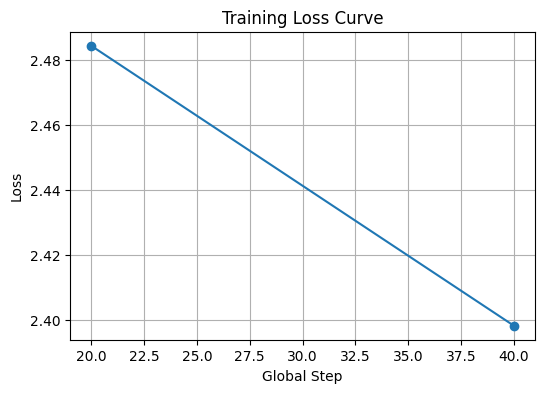

In [37]:
plt.figure(figsize=(6,4))
plt.plot(steps, losses, marker="o")
plt.title("Training Loss Curve")
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

**Evaluation loss**

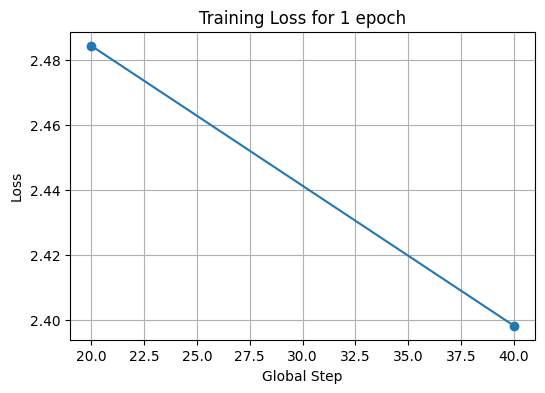

In [46]:
import matplotlib.pyplot as plt


train_logs = [x for x in trainer.state.log_history if "loss" in x and "learning_rate" in x]
t_steps  = [x["step"] for x in train_logs]
t_losses = [x["loss"] for x in train_logs]

plt.figure(figsize=(6,4))
plt.plot(t_steps, t_losses, marker="o")
plt.title("Training Loss for 1 epoch")
plt.xlabel("Global Step"); plt.ylabel("Loss"); plt.grid(True)
plt.show()



### **5 epochs**

In [23]:
model = AutoModelForMaskedLM.from_pretrained(MODEL_NAME)

args = TrainingArguments(
    output_dir=output_dir,                    # folder to save checkpoints
    num_train_epochs=5,
    per_device_train_batch_size=per_device_train_batch_size,
    save_strategy="epoch",                    # save after each epoch
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    warmup_ratio=warmup_ratio,
    report_to="none"
    # no logging
)

#Create trainer (no eval dataset)
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=lm_train,
    data_collator=data_collator,
    processing_class=tokenizer,
)


trainer.train()
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

print(f"Saved to: {output_dir}")


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Saved to: /content/drive/MyDrive/BERT_TP2/ckpt_demo


**Evaluation metrics**

In [25]:
import math

metrics = trainer.evaluate(eval_dataset=lm_valid)  # calcule la loss sur la validation
loss = metrics["eval_loss"]
ppl  = math.exp(loss) if loss < 20 else float("inf")  # perplexité = exp(loss)

print(f"Eval loss: {loss:.4f}")
print(f"Perplexity: {ppl:.2f}")


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Eval loss: 1.7969
Perplexity: 6.03


**Interpretation**

In [47]:
if loss > 6:
    comment = "Very high (tiny dataset / undertraining)."
elif loss > 3:
    comment = "High (expected for a small CPU demo)."
elif loss > 2:
    comment = "Acceptable for a demo."
else:
    comment = "Good for a small sample."
print("Interpretation:", comment)

Interpretation: Good for a small sample.


## **Train and validation curves** (for 5 epochs)

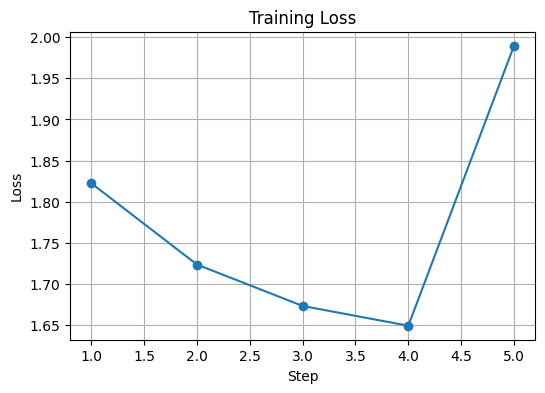

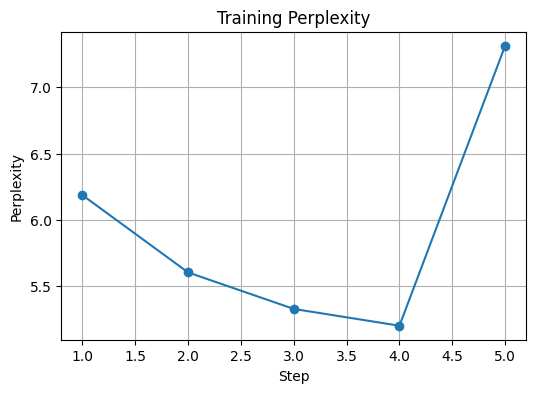

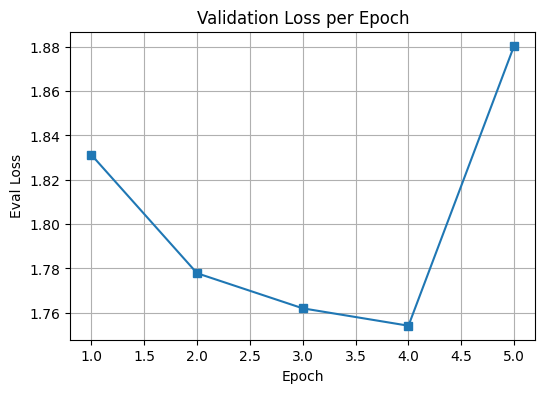

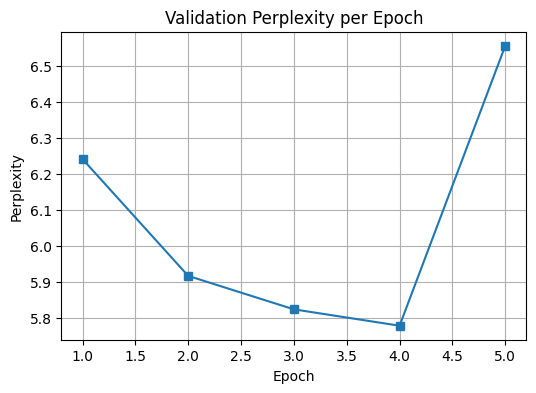

In [44]:

import os, glob, json, math
import matplotlib.pyplot as plt
from transformers import AutoModelForMaskedLM, Trainer, TrainingArguments

def exp_capped(x: float) -> float:
    return math.exp(x) if x < 20 else float("inf")

state_path = os.path.join(output_dir, "trainer_state.json")

train_x, train_loss, train_ppl = [], [], []
eval_x,  eval_loss,  eval_ppl  = [], [], []

if os.path.exists(state_path):
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)
    logs = state.get("log_history", [])

    # training loss per step
    tlogs = [x for x in logs if "loss" in x and "learning_rate" in x]
    train_x    = [x["step"] for x in tlogs]
    train_loss = [float(x["loss"]) for x in tlogs]
    train_ppl  = [exp_capped(l) for l in train_loss]

    # eval loss per epoch
    elogs = [x for x in logs if "eval_loss" in x and "epoch" in x]
    eval_x    = [float(x["epoch"]) for x in elogs]
    eval_loss = [float(x["eval_loss"]) for x in elogs]
    eval_ppl  = [exp_capped(l) for l in eval_loss]

else:
    ckpts = sorted(glob.glob(os.path.join(output_dir, "checkpoint-*")))
    if not ckpts:
        raise FileNotFoundError(
            "No trainer_state.json or checkpoint-* folders found in output_dir. "
            "Re-run training with save_strategy='epoch' to create checkpoints."
        )

    for i, ck in enumerate(ckpts, start=1):
        model = AutoModelForMaskedLM.from_pretrained(ck)
        args = TrainingArguments(output_dir=os.path.join(ck, "tmp"), report_to="none")
        tr = Trainer(model=model, args=args, data_collator=data_collator, processing_class=tokenizer)

        # "Training loss" ≈ eval on training split (post-hoc approximation)
        mt = tr.evaluate(eval_dataset=lm_train)
        me = tr.evaluate(eval_dataset=lm_valid)

        train_x.append(i)
        train_loss.append(float(mt["eval_loss"]))
        train_ppl.append(exp_capped(train_loss[-1]))

        eval_x.append(i)
        eval_loss.append(float(me["eval_loss"]))
        eval_ppl.append(exp_capped(eval_loss[-1]))


if train_x:
    plt.figure(figsize=(6,4))
    plt.plot(train_x, train_loss, marker="o")
    plt.title("Training Loss")
    plt.xlabel("Step" if any(isinstance(x, int) for x in train_x) else "Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(train_x, train_ppl, marker="o")
    plt.title("Training Perplexity")
    plt.xlabel("Step" if any(isinstance(x, int) for x in train_x) else "Epoch")
    plt.ylabel("Perplexity")
    plt.grid(True)
    plt.show()
else:
    print("No training logs found.")


if eval_x:
    plt.figure(figsize=(6,4))
    plt.plot(eval_x, eval_loss, marker="s")
    plt.title("Validation Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Eval Loss")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(eval_x, eval_ppl, marker="s")
    plt.title("Validation Perplexity per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Perplexity")
    plt.grid(True)
    plt.show()
else:
    print("No evaluation logs found (no eval during training and no checkpoints to reconstruct).")


## **Experimentation**

In [48]:
fill_mask = pipeline("fill-mask", model=model, tokenizer=tokenizer)

examples = [
    "Machine learning is [MASK] for modern AI.",
    "Paris is the [MASK] of France.",
    "The BERT model trains with a [MASK] objective.",
]

for s in examples:
    print("\n", s)
    for pred in fill_mask(s)[:5]:
        print(f"  -> {pred['token_str'].strip()!r} (p={pred['score']:.3f})")


Device set to use cpu



 Machine learning is [MASK] for modern AI.
  -> 'important' (p=0.193)
  -> 'essential' (p=0.169)
  -> 'critical' (p=0.128)
  -> 'used' (p=0.082)
  -> 'crucial' (p=0.036)

 Paris is the [MASK] of France.
  -> 'capital' (p=0.992)
  -> 'heart' (p=0.002)
  -> 'center' (p=0.001)
  -> 'centre' (p=0.001)
  -> 'city' (p=0.001)

 The BERT model trains with a [MASK] objective.
  -> 'single' (p=0.202)
  -> 'specific' (p=0.097)
  -> 'particular' (p=0.029)
  -> 'strategic' (p=0.028)
  -> 'design' (p=0.025)


## **Readme file**

In [45]:

readme_path = os.path.join(output_dir, "README_DEMO.txt")
with open(readme_path, "w", encoding="utf-8") as f:
    f.write(
        "Cette sauvegarde contient:\n"
        "- le modèle fine-tuné (pytorch_model.bin)\n"
        "- la config (config.json)\n"
        "- le tokenizer\n"
        "- un court entraînement sur un petit sous-échantillon (démo 5 époques)\n"
    )
print("README écrit:", readme_path)


README écrit: /content/drive/MyDrive/BERT_TP2/ckpt_demo/README_DEMO.txt
